In [14]:
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [1]:
import tensorflow as tf
tf.__version__

'2.4.0'

Loading model...Done! Took 5.654629230499268 seconds
Running inference for C:/Users/MYTHRY/Desktop/poc2/Invoice/fast2/images/Train/0_7175.pdf.jpg... WARNING:tensorflow:6 out of the last 6 calls to <function recreate_function.<locals>.restored_function_body at 0x000001F32453BCA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Done
{3: '1,19,593.0C\n', 2: 'sT/7175\n', 4: 'BizzWorld Technologies pvt ltd\n', 1: '31-12-2019\n'}


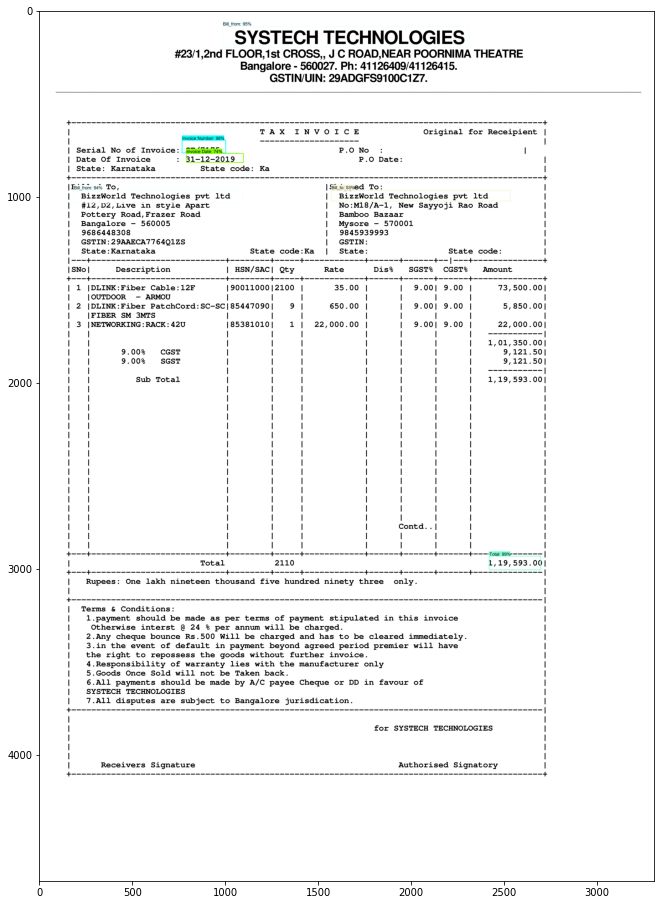

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import glob

warnings.filterwarnings('ignore') 
# Suppress Matplotlib warnings

# Enable GPU dynamic memory allocation

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
#pytesseract   
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
#test_image_path    
IMAGE_PATHS = 'C:/Users/MYTHRY/Desktop/poc2/Invoice/fast2/images/Train/0_7175.pdf.jpg'
# trained model_path
PATH_TO_MODEL_DIR = 'C:/Users/MYTHRY/Desktop/poc2/Invoice/fast2/exported-models/my_model'
# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = 'C:/Users/MYTHRY/Desktop/poc2/Invoice/fast2/Annotation/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)
#load the model
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
print('Loading model...', end='')
start_time = time.time()
# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))
# LOAD LABEL MAP DATA FOR PLOTTING
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)
def load_image_into_numpy_array(path):
    
    return np.array(Image.open(path))

print('Running inference for {}... '.format(IMAGE_PATHS), end='')


image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)
# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]
# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)
# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
#cv2.imshow(image_with_detections,IMAGE_PATHS)
cv2.imwrite(r'C:\Users\MYTHRY\Desktop\poc2\Invoice\fast2\deployment\static\FaterRcnn_prediction\img.jpg', image_with_detections)
plt.figure(figsize=(12,16))
plt.imshow(image_with_detections)
#cv2.waitKey(0)# CLOSES WINDOW ONCE KEY IS PRESSED
# bounding box prediction
data=detections['detection_scores']
t=np.where(data>0.6)
#print(detections['detection_scores'][t])
#print(detections['detection_boxes'][t])
dete_box=detections['detection_boxes'][t]
#le=len(dete_box)
#ymin,xmin,ymax,xmax
det_cla=detections['detection_classes'][t]
#1:Invoice Date #2:Invoice Number #3.Total#4.Bill_from #5.Bill_to
#results_dir=r'C:\Users\MYTHRY\Desktop\poc2\Invoice\fast2\static\Cropped_image'
(frame_height, frame_width) = image.shape[:2]
c = 0
for i in dete_box.tolist():
    #print(i)
    ymin = int((i[0]*frame_height))
    xmin = int((i[1]*frame_width))
    ymax = int((i[2]*frame_height))
    xmax = int((i[3]*frame_width))
    crop_img = image[ymin:ymax,xmin:xmax]
    #plt.imshow((crop_img))
    #to save croped image
    cv2.imwrite(f'C:/Users/MYTHRY/Desktop/poc2/Invoice/fast2/deployment/static/Cropped_image/image_{c}.png'.format(c),crop_img)
    c+=1
#to extract the text
results_dir=r'deployment/static/Cropped_image'
#text extraction
text=[]
import glob
cv_img = []
for img in glob.glob(r"C:\Users\MYTHRY\Desktop\poc2\Invoice\fast2\deployment\static\Cropped_image\*.png"):
    text_img= cv2.imread(img)
    #print(text_img)
    text1 = pytesseract.image_to_string(text_img)
    #print(text1)
    text.append(text1)

dict_from_list = {k: v for k, v in zip(det_cla, text)}

print(dict_from_list)
        


    



In [173]:

text=[]
import glob
cv_img = []
for img in glob.glob(r"C:\Users\MYTHRY\Desktop\poc2\Invoice\fast2\static\Cropped_image/*.png"):
    text_img= cv2.imread(img)
    #print(text_img)
    text1 = pytesseract.image_to_string(text_img)
    print(text1)
    text.append(text1)

dict_from_list = {k: v for k, v in zip(det_cla, text)}


1,19,593.0C

sT/7175

SYSTECH TECHNOLOGIES

BizzWorld Technologies pvt ltd

31-12-2019



In [5]:
dict_from_list

{3: '1,19,593.0C\n',
 2: 'sT/7175\n',
 4: 'BizzWorld Technologies pvt ltd\n',
 1: '31-12-2019\n'}

In [9]:
for i in dict_from_list.values():
    print(i)
        
        

1,19,593.0C

sT/7175

BizzWorld Technologies pvt ltd

31-12-2019



In [12]:
dict_from_list

{3: '1,19,593.0C\n',
 2: 'sT/7175\n',
 4: 'BizzWorld Technologies pvt ltd\n',
 1: '31-12-2019\n'}